In [303]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.model_selection import KFold

from transcriptomics.visualization import figures as fig
from transcriptomics.gec_functions_ana import _get_gene_symbols, return_thresholded_data
from transcriptomics.constants import Defaults

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
# load thresholded dataframe - all samples

df = return_thresholded_data(atlas='MDTB-10-subRegions', which_genes='top', atlas_other="MDTB-10", percentile=1, all_samples=True)

genes = _get_gene_symbols(atlas="MDTB-10", which_genes='top', percentile=1)



In [292]:
np.random.seed(47)

X = df[genes]
Y = df['region_num']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

In [304]:
def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 4 models total.
    Return the average MSE of these 4 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):

        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
      
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        error = rmse(model.predict(split_X_valid), split_Y_valid)

        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [305]:
def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groudtruth
    """
    return np.sqrt(np.mean((actual_y - predicted_y) ** 2)) 

### However, if we plot the training and test error as we add each additional feature, we see that our model is beginning to overfit. That is, even though our training error continues to decrease (since our model variance is decreasing), our test error starts increasing since the lessons learned from these last 75 features aren't actually useful when applied to unseen data. That is, our model isn't generalizable.

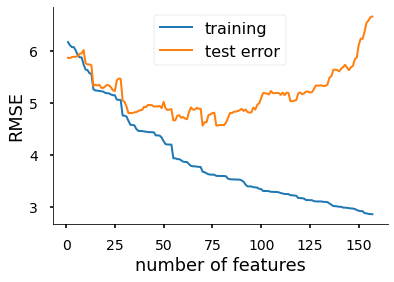

In [313]:
train_error_vs_N = []
test_error_vs_N = []

range_of_num_features = range(1, X_train.shape[1] + 1)

for N in range_of_num_features:
    X_train_first_N_features = X_train.iloc[:, :N]    
    
    linear_model.fit(X_train_first_N_features, Y_train)
    train_error = rmse(Y_train, linear_model.predict(X_train_first_N_features))
    train_error_vs_N.append(train_error)
    
    X_test_first_N_features = X_test.iloc[:, :N]
    test_error = rmse(Y_test, linear_model.predict(X_test_first_N_features))    
    test_error_vs_N.append(test_error)
    
plt.plot(range_of_num_features, train_error_vs_N)
plt.plot(range_of_num_features, test_error_vs_N)
plt.legend(["training", "test error"])
plt.xlabel("number of features")
plt.ylabel("RMSE");

### Use compute_CV_error to determine how many of the first $N$ features should be used to get the lowest average validation error. Then, fill in the variables best_num_features, best_err.

In [307]:
range_of_num_features = range(1, X_train.shape[1] + 1)

errors = []
for N in range_of_num_features:
    print(f"Trying first {N} features")
    model = lm.LinearRegression()
    
    # compute the cross validation error
    error = compute_CV_error(model, X_train.iloc[:, :N],Y_train) 
    
    print("\tRMSE:", error)
    errors.append(error)

best_num_features = np.argmin(errors) + 1
best_err = errors[best_num_features - 1]

print(f"Best choice, use the first {best_num_features} features")

Trying first 1 features
	RMSE: 6.264885685368316
Trying first 2 features
	RMSE: 6.202174950041529
Trying first 3 features
	RMSE: 6.210379530525644
Trying first 4 features
	RMSE: 6.221807508170482
Trying first 5 features
	RMSE: 6.190974685379714
Trying first 6 features
	RMSE: 6.101097419526743
Trying first 7 features
	RMSE: 6.091414474742035
Trying first 8 features
	RMSE: 6.115795476607035
Trying first 9 features
	RMSE: 6.008394840899247
Trying first 10 features
	RMSE: 5.8929063994063196
Trying first 11 features
	RMSE: 5.934365041340003
Trying first 12 features
	RMSE: 5.895823413925757
Trying first 13 features
	RMSE: 5.9069902201159525
Trying first 14 features
	RMSE: 5.721142514747461
Trying first 15 features
	RMSE: 5.7165648951364645
Trying first 16 features
	RMSE: 5.753550173625298
Trying first 17 features
	RMSE: 5.732270298755459
Trying first 18 features
	RMSE: 5.766822670150724
Trying first 19 features
	RMSE: 5.789980188485484
Trying first 20 features
	RMSE: 5.7835443959237836
Tryin

### Fit a linear model using the best feature set and predict samples for original test set. Compute the final train and test RMSEs for a linear model using the best feature set.

In [308]:
# Fit linear model
model = lm.LinearRegression()
model.fit(X_train.iloc[:, :best_num_features], Y_train)
train_rmse = rmse(model.predict(X_train.iloc[:, :best_num_features]), Y_train) 
test_rmse = rmse(model.predict(X_test.iloc[:, :best_num_features]), Y_test)

print("Train RMSE", train_rmse)
print("KFold Validation RMSE", best_err)
print("Test RMSE", test_rmse)

Train RMSE 3.6288235317785733
KFold Validation RMSE 5.264264010531905
Test RMSE 4.783387714493078


### Here we plot a residual plot for each record from X_test. After seeing the testing and training error, it is often helpful to visiualize the error. When points in the residual plot are randomly scattered around the line y = 0, then we know that a linear regression model is good for the data we have.

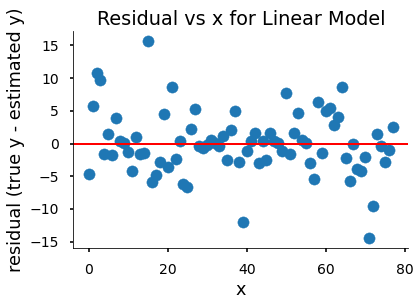

In [310]:
plt.scatter(np.arange(len(X_test)), Y_test - model.predict(X_test.iloc[:, :best_num_features]))
plt.xlabel('x')
plt.ylabel('residual (true y - estimated y)')
plt.title('Residual vs x for Linear Model')
plt.axhline(y = 0, color='r');